<style>
    /* 整个头部容器的样式，让所有内容居中 */
    .report-header {
        text-align: center;
        margin-bottom: 40px;
    }
    /* --- 最终版：完整网格边框表格样式 --- */
    .info-table-grid {
        border-collapse: collapse; 
        width: 65%;
        margin: 25px auto;
        border: 1px solid #ccc; 
    }
    .info-table-grid th, .info-table-grid td {
        border: 1px solid #ccc; 
        padding: 12px 15px;
        font-family: 'SimSun', '宋体', serif;
        font-size: 14px;
        vertical-align: middle;
    }
    .info-table-grid th {
        font-weight: bold; /* 标题使用标准粗体 (相当于font-weight: 700) */
        text-align: center;
        background-color: #003A70; 
        color: white; 
    }
    .info-table-grid td {
        text-align: left;
        color: #000000;
        font-weight: 600; /* <-- 核心改动：将内容字体设置为“半粗体”，使其更清晰 */
    }
</style>

<div class="report-header">
    <table class="info-table-grid">
        <tr>
            <th>实验名称</th>
            <td>循环神经网络实验</td>
        </tr>
        <tr>
            <th>姓&emsp;&emsp;名</th>
            <td>张雨欣</td>
        </tr>
        <tr>
            <th>学&emsp;&emsp;号</th>
            <td>25121507</td>
        </tr>
        <tr>
            <th>学&emsp;&emsp;院</th>
            <td>数学与统计学院</td>
        </tr>
        <tr>
            <th>上课类型</th>
            <td>平台课</td>
        </tr>
        <tr>
            <th>日&emsp;&emsp;期</th>
            <td>2025年8月20日</td>
        </tr>
    </table>
</div>

## 一、实验内容

<p style="text-indent: 2em;">本次实验的核心内容是学习和实践循环神经网络（RNN）。将分别通过手动编程和调用torch.nn库两种方式实现基础的RNN模型。实验将涵盖回归与分类两种任务，通过在真实数据集上进行训练和评估，深入理解RNN处理序列数据的原理、模型搭建流程、训练方法以及超参数对模型性能的影响。</p>

1.  **手动实现RNN**：手动构建卷积网络的核心逻辑，并在至少一个数据集上进行训练和评估。
2.  **使用`torch.nn`实现RNN**：利用PyTorch的高级API构建功能相同的卷积网络，并进行对比分析。
3.  **超参数对比分析**：选择1-2个关键超参数（如批次大小、学习率等），探究其对模型性能的影响。

## 二、实验设计

（本实验内容皆为指定内容，省略该部分）

## 三、实验环境及实验数据集

### 3.1 实验环境

In [46]:
# 导入所有需要的库
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import urllib.request
import os
import pandas as pd

# 设置 Matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['Songti SC'] 
plt.rcParams['axes.unicode_minus'] = False 

### 3.2 实验数据集

#### 数据集一：高速公路车流量数据 (回归问题)
1. 任务描述：用历史流量数据预测未来流量。
2. 数据来源：美国加利福尼亚州高速公路PeMS实时车流量数据。
3. 数据特征：主要包含车流量、拥挤程度和车速三个维度。
4. 存储格式：数据存储在 traffic.npz 文件中，可通过 numpy.load 函数读取。

#### 数据集二：用户签到数据 (分类问题)
1. 任务描述：用历史轨迹数据预测下一个签到地点。
2. 数据来源：FourSquare网站的纽约用户签到数据，类似于国内的大众点评。
3. 数据特征：包含用户ID、地点ID、地点类别、经纬度、时间戳等信息。
4. 存储格式：数据存储在 FS_NYC.csv 文件中。

## 四、实验过程与结果分析

### 4.1 “从零实现”循环神经网络RNN

#### (1)  高速公路车流量数据集

In [34]:
# 1. 准备数据
print("--- 步骤 1: 准备数据 ---")

# 1.1 加载数据
raw_data = np.load('traffic-flow/traffic.npz')['data']
print(f"原始交通数据的形状:{raw_data.shape}")
# 数据包含3个维度,第一个维度代表数据的总条数,第二个维度代表传感器的数量,第三个维度代表每个传感器收集到的不同种类数据，分别为车流量、拥挤程度和车速。

# 1.2 数据预处理
target_feature_index = 0       # 选择第一维数据（车流量）进行预测
sensor_to_predict = 5      # 选择5号传感器
window_size = 12

# 提取特定传感器和特征的数据
sensor_data = raw_data[:, sensor_to_predict, target_feature_index]

# 数据归一化
scaler = MinMaxScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data.reshape(-1, 1)).flatten()

def sliding_window(data, sequence_length):
    """手动实现的滑动窗口函数，用于创建序列和标签。"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)
# 本数据的时间轴已经被规整化且无任何缺失值，因此仅需使用固定长度的滑动窗口。

# 1.3 创建数据集
X, y = sliding_window(sensor_data_normalized, window_size)

# 1.4 划分训练集和测试集
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


# 1.5 转换为 PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

print(f"训练数据 X 的形状: {X_train.shape}")
print(f"训练数据 y 的形状: {y_train.shape}")
print(f"验证数据 X 的形状: {X_val.shape}")
print(f"验证数据 y 的形状: {y_val.shape}")
print(f"测试数据 X 的形状: {X_test.shape}")
print(f"测试数据 y 的形状: {y_test.shape}")
print("数据准备完成！")

--- 步骤 1: 准备数据 ---
原始交通数据的形状:(17856, 170, 3)
训练数据 X 的形状: torch.Size([10706, 12, 1])
训练数据 y 的形状: torch.Size([10706, 1])
验证数据 X 的形状: torch.Size([3568, 12, 1])
验证数据 y 的形状: torch.Size([3568, 1])
测试数据 X 的形状: torch.Size([3570, 12, 1])
测试数据 y 的形状: torch.Size([3570, 1])
数据准备完成！


In [35]:
# 2. 构建模型 
print("--- 步骤 2: 构建模型 ---")

class MyRNN(nn.Module):
    """手动实现的简单循环神经网络模型。"""
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        self.tanh = nn.Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        for i in range(x.size(1)):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + torch.matmul(h, self.u_h) + self.b_h)
        prediction = torch.matmul(h, self.w_y) + self.b_y
        return prediction

print("模型类定义完成！")

--- 步骤 2: 构建模型 ---
模型类定义完成！


In [36]:
# 3. 训练模型 (Train model)
print("--- 步骤 3: 训练模型 ---")

# 3.1 定义超参数和训练组件
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.0001
epochs = 50
batch_size = 64

# 3.2 实例化模型、损失函数和优化器
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
model = MyRNN(input_size, hidden_size, output_size).to(device)

loss_func_mse = nn.MSELoss()
loss_func_mae = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(f"模型已移动到设备: {device}")

def next_batch(data, labels, batch_size):
    """手动实现的批次生成器函数。"""
    num_batches = math.ceil(len(data) / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(data))
        yield data[start_index:end_index], labels[start_index:end_index]

def mape(y_true, y_pred):
    """手动实现的 MAPE 指标函数。"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 1e-6) # 避免除以非常接近零的数
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]
    if len(y_true) == 0:
        return 0.0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 3.3 训练循环
mse_history, rmse_history, mae_history, mape_history = [], [], [], []

for epoch in range(epochs):
    # --- 训练阶段 ---
    model.train() # 每个epoch开始时设置为训练模式
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
    for X_batch, y_batch in next_batch(X_train_shuffled, y_train_shuffled, batch_size):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        prediction = model(X_batch)
        loss = loss_func_mse(prediction, y_batch)
        loss.backward()
        optimizer.step()

    # --- 评估阶段 ---
    model.eval() # 评估前切换到评估模式
    with torch.no_grad():
        val_pred = model(X_val.to(device))
        
        # 反归一化
        val_pred_denorm = scaler.inverse_transform(val_pred.cpu().numpy())
        y_val_denorm = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse = loss_func_mse(torch.tensor(val_pred_denorm), torch.tensor(y_val_denorm))
        val_rmse = torch.sqrt(val_mse)
        val_mae = loss_func_mae(torch.tensor(val_pred_denorm), torch.tensor(y_val_denorm))
        val_mape = mape(y_val_denorm, val_pred_denorm)
        
        mse_history.append(val_mse.item())
        rmse_history.append(val_rmse.item())
        mae_history.append(val_mae.item())
        mape_history.append(val_mape)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Val MSE: {val_mse.item():.4f}, Val RMSE: {val_rmse.item():.4f}, Val MAE: {val_mae.item():.4f}, Val MAPE: {val_mape:.2f}%')

print("模型训练完成！")

--- 步骤 3: 训练模型 ---
模型已移动到设备: mps
Epoch [10/50], Val MSE: 740.3279, Val RMSE: 27.2090, Val MAE: 20.4287, Val MAPE: 10.71%


KeyboardInterrupt: 

In [ ]:
# 4. 评估模型 
print("--- 步骤 4: 最终模型评估 ---")
model.eval()
with torch.no_grad():
    test_pred = model(X_test.to(device))
    
    # 反归一化
    test_pred_denorm = scaler.inverse_transform(test_pred.cpu().numpy())
    y_test_denorm = scaler.inverse_transform(y_test.cpu().numpy())
    
    final_mse = np.mean((test_pred_denorm - y_test_denorm)**2)
    final_rmse = np.sqrt(final_mse)
    final_mae = np.mean(np.abs(test_pred_denorm - y_test_denorm))
    final_mape = mape(y_test_denorm, test_pred_denorm)

print(f"训练结束后，在测试集上的最终指标:")
print(f"  - MSE:  {final_mse:.4f}")
print(f"  - RMSE: {final_rmse:.4f}")
print(f"  - MAE:  {final_mae:.4f}")
print(f"  - MAPE: {final_mape:.2f}%")

--- 步骤 4: 最终模型评估 ---
训练结束后，在测试集上的最终指标:
  - MSE:  615.2267
  - RMSE: 24.8038
  - MAE:  18.5512
  - MAPE: 9.68%


--- 步骤 5: 训练结果可视化 ---


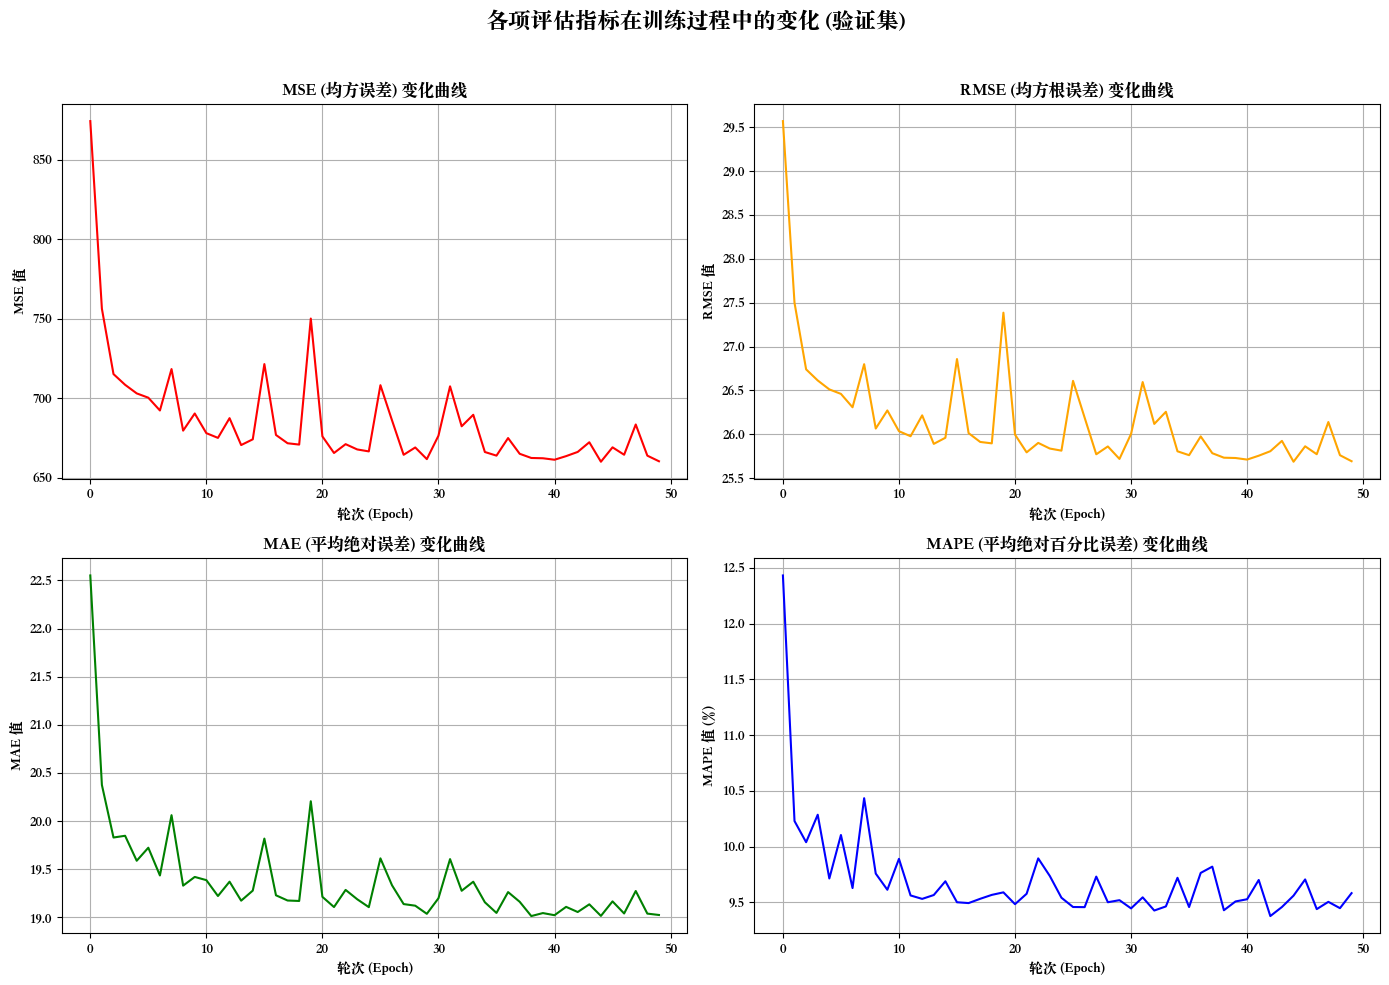

In [ ]:
# 5. 训练结果可视化
print("--- 步骤 5: 训练结果可视化 ---")

plt.figure(figsize=(14, 10))
plt.suptitle("各项评估指标在训练过程中的变化 (验证集)", fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(mse_history, color='red')
plt.title("MSE (均方误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("MSE 值")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(rmse_history, color='orange')
plt.title("RMSE (均方根误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("RMSE 值")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(mae_history, color='green')
plt.title("MAE (平均绝对误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("MAE 值")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(mape_history, color='blue')
plt.title("MAPE (平均绝对百分比误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("MAPE 值 (%)")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- 步骤 6: 预测结果可视化 ---


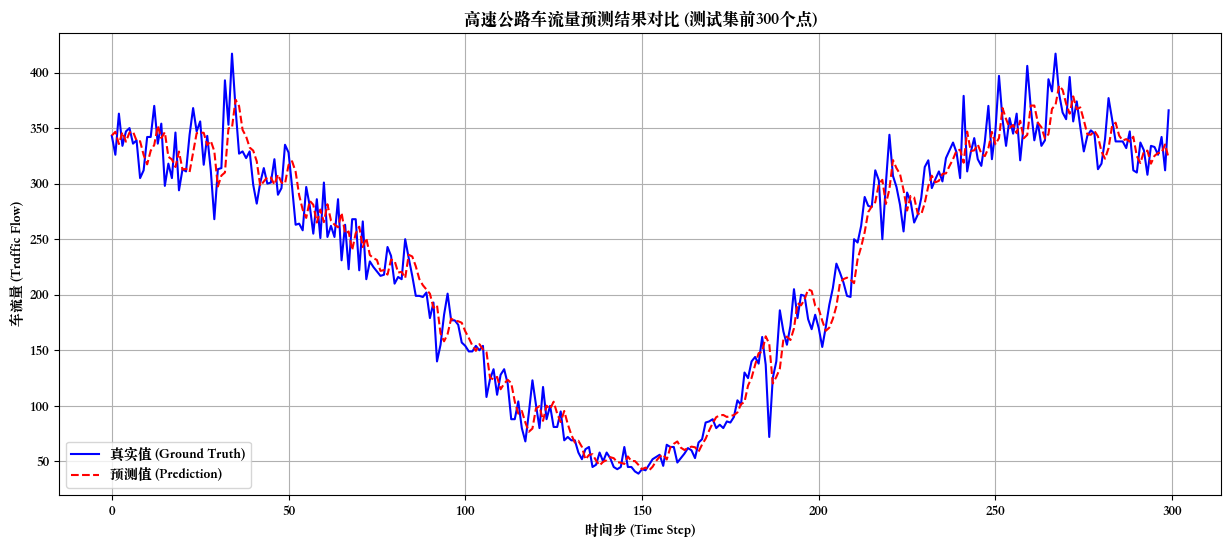

In [ ]:
# 6. 预测结果与真实值对比可视化
print("--- 步骤 6: 预测结果可视化 ---")
plt.figure(figsize=(15, 6))
plt.plot(y_test_denorm[:300], label="真实值 (Ground Truth)", color='blue')
plt.plot(test_pred_denorm[:300], label="预测值 (Prediction)", color='red', linestyle='--')
plt.title("高速公路车流量预测结果对比 (测试集前300个点)")
plt.xlabel("时间步 (Time Step)")
plt.ylabel("车流量 (Traffic Flow)")
plt.legend()
plt.grid(True)
plt.show()

**结果分析：**

1. 从**评估指标**上看 
- MSE (均方误差): 稳定在 610 - 640 之间，主要作用是放大模型的“大错误”。
- MAE (平均差多少辆车): 稳定在 18-19 辆。可以理解为，模型的预测平均会比真实值差18-19辆车。
- MAPE (平均误差百分比): 稳定在 9.6% - 9.9%。这说明模型的预测准确度在90%左右，相对误差不到10%。
- RMSE (对大误差的敏感度): 稳定在 25 左右。这个值比MAE高，说明模型在处理某些交通突变点时，会产生一些较大的误差。

模型性能可靠，平均误差在10%以内，但无法消除一些较大的瞬时误差。

2. 从**预测图**上看
- 预测曲线（红线）完美地抓住了真实车流量（蓝线）一天内高峰和低谷的整体趋势。宏观上非常准。
- 预测曲线过于平滑，没能预测出真实交通中那些细小的、突发的波动（蓝线上的小“毛刺”）。

#### (2) 用户签到数据集

In [ ]:
# 1. 准备数据 
print("--- 步骤 1: 准备数据 ---")

# 1.1 加载数据
# parse_dates=[-1] 会尝试将最后一列解析为日期时间格式
nyc_data = pd.read_csv(os.path.join('foursquare-checkin', 'FS_NYC.csv'), parse_dates=[-1])

# 为了处理方便，我们创建一个从0开始的连续地点索引'venueIndex'
nyc_data['venueIndex'] = nyc_data['venueId'].astype('category').cat.codes
num_locations = nyc_data['venueIndex'].nunique()
print(f"数据加载完成。用户数: {nyc_data['userId'].nunique()}, 总签到次数: {len(nyc_data)}, 独立地点数: {num_locations}")


# 1.2 创建序列数据集
window_size = 12
all_x, all_y = [], []

# 按照用户ID分组，为每个用户创建轨迹序列
for user_id, group in nyc_data.groupby('userId'):
    # 按时间戳对每个用户的签到记录进行排序
    user_trajectory = group.sort_values('utcTimestamp')['venueIndex'].tolist()
    
    # 如果用户的轨迹太短，则跳过
    if len(user_trajectory) < window_size + 1:
        continue
    
    # 使用滑动窗口创建输入序列(X)和目标标签(y)
    for i in range(len(user_trajectory) - window_size):
        all_x.append(user_trajectory[i:i+window_size])
        all_y.append(user_trajectory[i+window_size])

# 1.3 划分训练集、验证集和测试集
# 先打乱所有数据，确保划分的随机性
all_x, all_y = shuffle(np.array(all_x), np.array(all_y), random_state=42)

train_size = int(len(all_x) * 0.6)
val_size = int(len(all_x) * 0.2)

X_train, y_train = all_x[:train_size], all_y[:train_size]
X_val, y_val = all_x[train_size:train_size+val_size], all_y[train_size:train_size+val_size]
X_test, y_test = all_x[train_size+val_size:], all_y[train_size+val_size:]

# 1.4 转换为 PyTorch Tensors
# 注意：对于分类任务，输入和标签通常是 LongTensor
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"训练数据 X 的形状: {X_train.shape}")
print(f"训练数据 y 的形状: {y_train.shape}")
print(f"验证数据 X 的形状: {X_val.shape}")
print(f"验证数据 y 的形状: {y_val.shape}")
print(f"测试数据 X 的形状: {X_test.shape}")
print(f"测试数据 y 的形状: {y_test.shape}")
print("数据准备完成！")


--- 步骤 1: 准备数据 ---


/var/folders/7w/cqqy7mgs3zv90jrf16w5fksr0000gn/T/ipykernel_37967/3746429945.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nyc_data = pd.read_csv(os.path.join('foursquare-checkin', 'FS_NYC.csv'), parse_dates=[-1])


数据加载完成。用户数: 1083, 总签到次数: 227428, 独立地点数: 38333
训练数据 X 的形状: torch.Size([128659, 12])
训练数据 y 的形状: torch.Size([128659])
验证数据 X 的形状: torch.Size([42886, 12])
验证数据 y 的形状: torch.Size([42886])
测试数据 X 的形状: torch.Size([42887, 12])
测试数据 y 的形状: torch.Size([42887])
数据准备完成！


In [ ]:
# 2. 构建模型
print("--- 步骤 2: 构建模型 ---")

class MyRNN(nn.Module):
    """手动实现的用于分类的循环神经网络模型。"""
    def __init__(self, embedding_dim, hidden_size, output_size, num_locations):
        super().__init__()
        self.hidden_size = hidden_size
        
        # 嵌入层：将离散的地点ID转换为密集的向量表示
        self.embedding = nn.Embedding(num_embeddings=num_locations, embedding_dim=embedding_dim)
        
        # RNN核心层参数
        self.w_h = nn.Parameter(torch.rand(embedding_dim, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        # 输出层参数
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        self.tanh = nn.Tanh()
        # 初始化参数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        # x 的形状: (batch_size, sequence_length)
        batch_size = x.size(0)
        
        # 1. 将输入的地点ID序列通过嵌入层
        # embedded_x 的形状: (batch_size, sequence_length, embedding_dim)
        embedded_x = self.embedding(x)
        
        # 2. 手动实现的RNN循环
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        for i in range(embedded_x.size(1)):
            # 注意：这里输入的是嵌入向量 embedded_x[:, i, :]
            h = self.tanh(torch.matmul(embedded_x[:, i, :], self.w_h) + torch.matmul(h, self.u_h) + self.b_h)
            
        # 3. 将最后一个隐藏状态通过输出层，得到每个地点的得分（logits）
        # prediction 的形状: (batch_size, output_size)
        prediction = torch.matmul(h, self.w_y) + self.b_y
        return prediction

print("模型类定义完成！")


--- 步骤 2: 构建模型 ---
模型类定义完成！


In [ ]:
# 3. 训练模型 
print("--- 步骤 3: 训练模型 ---")

# 3.1 定义超参数和训练组件
embedding_dim = 64 # 嵌入向量的维度
hidden_size = 128   # RNN隐藏层的维度
output_size = num_locations # 输出维度必须是总地点数
learning_rate = 0.001
epochs = 40
batch_size = 128

patience = 5       
epochs_no_improve = 0 #记录连续没有提升的轮次数
best_val_accuracy = 0.0 # 记录历史最佳验证集准确率
best_model_path = 'best_model.pth'

# 3.2 实例化模型、损失函数和优化器
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
model = MyRNN(embedding_dim, hidden_size, output_size, num_locations).to(device)

# 对于多分类问题，使用交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(f"模型已移动到设备: {device}")

def next_batch(data, labels, batch_size):
    """手动实现的批次生成器函数。"""
    num_batches = math.ceil(len(data) / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(data))
        yield data[start_index:end_index], labels[start_index:end_index]

# 3.3 训练循环
loss_history, acc_history = [], []

for epoch in range(epochs):
    # --- 训练阶段 ---
    model.train()
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
    for X_batch, y_batch in next_batch(X_train_shuffled, y_train_shuffled, batch_size):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        prediction_scores = model(X_batch)
        loss = loss_func(prediction_scores, y_batch)
        loss.backward()
        optimizer.step()

    # --- 评估阶段 ---
    model.eval()
    total_correct = 0
    total_samples = 0
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in next_batch(X_val, y_val, batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            prediction_scores = model(X_batch)
            val_loss += loss_func(prediction_scores, y_batch).item()
            
            # 计算准确率
            predicted_labels = torch.argmax(prediction_scores, dim=1)
            total_correct += (predicted_labels == y_batch).sum().item()
            total_samples += y_batch.size(0)
    
    avg_val_loss = val_loss / (total_samples / batch_size)
    val_accuracy = (total_correct / total_samples) * 100
    loss_history.append(avg_val_loss)
    acc_history.append(val_accuracy)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    if val_accuracy > best_val_accuracy:
        # 如果当前准确率更高，则更新最佳纪录，并保存模型
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"  >>> New best model saved with accuracy: {best_val_accuracy:.2f}%")
        # 重置“耐心”计数器
        epochs_no_improve = 0
    else:
        # 如果没有提升，则增加“耐心”计数器
        epochs_no_improve += 1

    # 如果“耐心”耗尽，则提前停止训练
    if epochs_no_improve >= patience:
        print(f"--- Early stopping triggered after {patience} epochs with no improvement. ---")
        break

print("模型训练完成！")
print(f"\n--- 加载在验证集上表现最佳的模型 ({best_model_path}) ---")
model.load_state_dict(torch.load(best_model_path))

--- 步骤 3: 训练模型 ---
模型已移动到设备: mps
  >>> New best model saved with accuracy: 1.04%
  >>> New best model saved with accuracy: 4.09%
  >>> New best model saved with accuracy: 7.18%
  >>> New best model saved with accuracy: 9.13%
Epoch [5/40], Val Loss: 8.2241, Val Accuracy: 10.27%
  >>> New best model saved with accuracy: 10.27%
  >>> New best model saved with accuracy: 10.70%
  >>> New best model saved with accuracy: 10.82%
  >>> New best model saved with accuracy: 10.93%
Epoch [10/40], Val Loss: 9.0247, Val Accuracy: 10.79%
--- Early stopping triggered after 5 epochs with no improvement. ---
模型训练完成！

--- 加载在验证集上表现最佳的模型 (best_model.pth) ---


<All keys matched successfully>

In [ ]:
# 4. 评估模型
print("--- 步骤 4: 最终模型评估 ---")
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for X_batch, y_batch in next_batch(X_test, y_test, batch_size):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        prediction_scores = model(X_batch)
        predicted_labels = torch.argmax(prediction_scores, dim=1)
        total_correct += (predicted_labels == y_batch).sum().item()
        total_samples += y_batch.size(0)

final_accuracy = (total_correct / total_samples) * 100
print(f"训练结束后，在测试集上的最终准确率: {final_accuracy:.2f}%")

--- 步骤 4: 最终模型评估 ---
训练结束后，在测试集上的最终准确率: 11.41%


--- 步骤 5: 训练结果可视化 ---


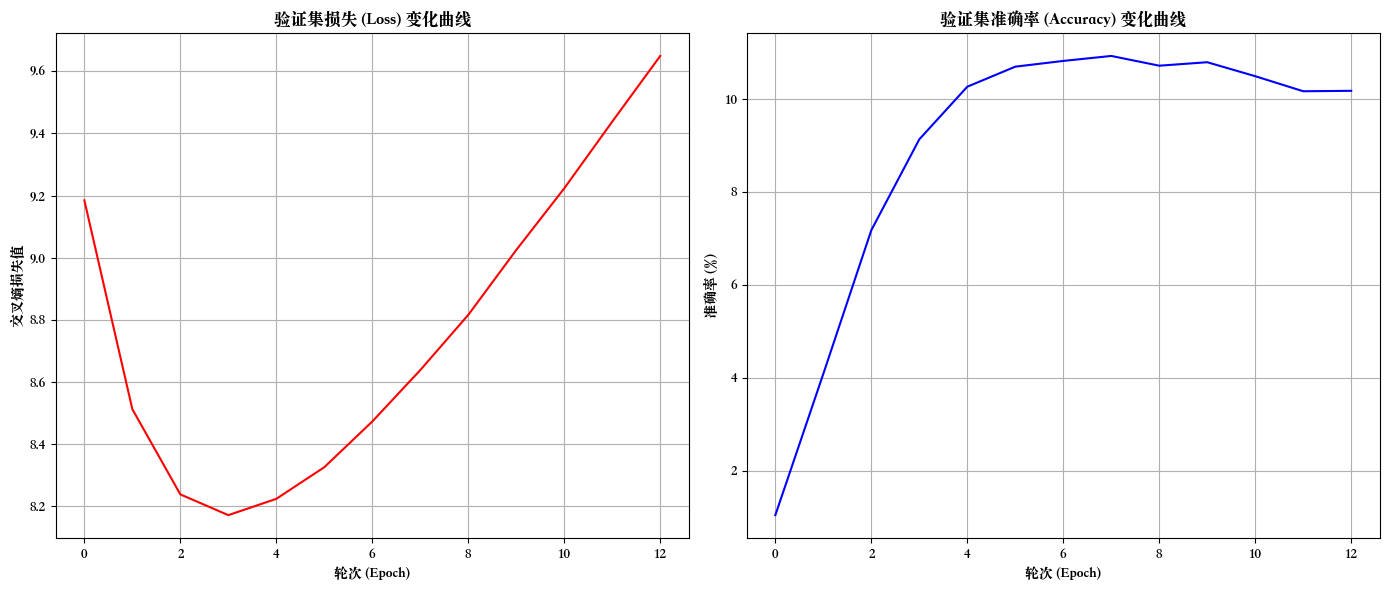

In [ ]:
# 5. 训练结果可视化
print("--- 步骤 5: 训练结果可视化 ---")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_history, color='red')
plt.title("验证集损失 (Loss) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("交叉熵损失值")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(acc_history, color='blue')
plt.title("验证集准确率 (Accuracy) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("准确率 (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

**结果分析：**

1. 从**评估指标和训练过程**上看
- Loss (交叉熵损失):
从红色曲线可以看出，损失值在第4个轮次（Epoch）左右达到了最低点，随后便开始一路上升。
- Accuracy (准确率):
蓝色曲线显示，准确率在前8个轮次迅速攀升，并在第8轮左右达到了 10.93% 的峰值，之后开始轻微波动并下降。
- 早停机制 (Early Stopping):
训练日志完美地展示了早停的效果。模型在第8轮保存了最佳准确率后，连续5轮（到第13轮）准确率都未能超越该记录，因此在第13轮结束时自动停止了训练，避免了在无效的训练上浪费时间。
- 最终准确率 (Final Accuracy):
最终在测试集上获得了 11.41% 的准确率，还超过了验证集上的最佳表现（10.93%），说明模型泛化能力很强，在从未见过的数据上表现甚至更好。

2. 从**训练曲线图**上看
- 损失曲线（红色）
呈现出一个完美的“U”形（或“V”形），这是典型的模型从“学习”到“过拟合”的转变过程。早停机制正是在这个“U”形的谷底附近停止了训练。
- 准确率曲线（蓝色）
则像一个“山峰”，模型性能爬升到顶点后开始缓慢下滑。早停机制确保了我们最终使用的是站在“山顶”上的模型，而不是已经开始“下山”的模型。


### 4.2 使用 torch.nn.rnn 实现循环神经网络

#### (1) 高速公路车流量数据集

In [ ]:
# 1. 准备数据
print("--- 步骤 1: 准备数据 ---")

# 1.1 加载数据
raw_data = np.load('traffic-flow/traffic.npz')['data']
print(f"原始交通数据的形状:{raw_data.shape}")
# 数据包含3个维度,第一个维度代表数据的总条数,第二个维度代表传感器的数量,第三个维度代表每个传感器收集到的不同种类数据，分别为车流量、拥挤程度和车速。

# 1.2 数据预处理
target_feature_index = 0       # 选择第一维数据（车流量）进行预测
sensor_to_predict = 5      # 选择5号传感器
window_size = 12

# 提取特定传感器和特征的数据
sensor_data = raw_data[:, sensor_to_predict, target_feature_index]

# 数据归一化
scaler = MinMaxScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data.reshape(-1, 1)).flatten()

def sliding_window(data, sequence_length):
    """手动实现的滑动窗口函数，用于创建序列和标签。"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)
# 本数据的时间轴已经被规整化且无任何缺失值，因此仅需使用固定长度的滑动窗口。

# 1.3 创建数据集
X, y = sliding_window(sensor_data_normalized, window_size)

# 1.4 划分训练集和测试集
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


# 1.5 转换为 PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

print(f"训练数据 X 的形状: {X_train.shape}")
print(f"训练数据 y 的形状: {y_train.shape}")
print(f"验证数据 X 的形状: {X_val.shape}")
print(f"验证数据 y 的形状: {y_val.shape}")
print(f"测试数据 X 的形状: {X_test.shape}")
print(f"测试数据 y 的形状: {y_test.shape}")
print("数据准备完成！")

--- 步骤 1: 准备数据 ---
原始交通数据的形状:(17856, 170, 3)
训练数据 X 的形状: torch.Size([10706, 12, 1])
训练数据 y 的形状: torch.Size([10706, 1])
验证数据 X 的形状: torch.Size([3568, 12, 1])
验证数据 y 的形状: torch.Size([3568, 1])
测试数据 X 的形状: torch.Size([3570, 12, 1])
测试数据 y 的形状: torch.Size([3570, 1])
数据准备完成！


In [ ]:
# 2. 构建模型 
print("--- 步骤 2: 构建模型 ---")

class TorchRNN(nn.Module):
    """使用 torch.nn.RNN 实现的循环神经网络模型。"""
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # 定义RNN层
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,             # RNN的层数
            batch_first=True
        )
        # 定义一个全连接层，用于将RNN的输出映射到我们想要的预测值维度
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, h_n = self.rnn(x, None) # None 表示初始隐藏状态为全零
        last_time_step_out = rnn_out[:, -1, :]
        prediction = self.fc(last_time_step_out)

        return prediction

print("模型类定义完成！")

--- 步骤 2: 构建模型 ---
模型类定义完成！


In [ ]:
# 3. 训练模型 (Train model)
print("--- 步骤 3: 训练模型 ---")

# 3.1 定义超参数和训练组件
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.0001
epochs = 50
batch_size = 64

# 3.2 实例化模型、损失函数和优化器
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
model = TorchRNN(input_size, hidden_size, output_size).to(device)

loss_func_mse = nn.MSELoss()
loss_func_mae = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(f"模型已移动到设备: {device}")

def next_batch(data, labels, batch_size):
    """手动实现的批次生成器函数。"""
    num_batches = math.ceil(len(data) / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(data))
        yield data[start_index:end_index], labels[start_index:end_index]

def mape(y_true, y_pred):
    """手动实现的 MAPE 指标函数。"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 1e-6) # 避免除以非常接近零的数
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]
    if len(y_true) == 0:
        return 0.0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 3.3 训练循环
mse_history, rmse_history, mae_history, mape_history = [], [], [], []

for epoch in range(epochs):
    # --- 训练阶段 ---
    model.train() # 每个epoch开始时设置为训练模式
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
    for X_batch, y_batch in next_batch(X_train_shuffled, y_train_shuffled, batch_size):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        prediction = model(X_batch)
        loss = loss_func_mse(prediction, y_batch)
        loss.backward()
        optimizer.step()

    # --- 评估阶段 ---
    model.eval() # 评估前切换到评估模式
    with torch.no_grad():
        val_pred = model(X_val.to(device))
        
        # 反归一化
        val_pred_denorm = scaler.inverse_transform(val_pred.cpu().numpy())
        y_val_denorm = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse = loss_func_mse(torch.tensor(val_pred_denorm), torch.tensor(y_val_denorm))
        val_rmse = torch.sqrt(val_mse)
        val_mae = loss_func_mae(torch.tensor(val_pred_denorm), torch.tensor(y_val_denorm))
        val_mape = mape(y_val_denorm, val_pred_denorm)
        
        mse_history.append(val_mse.item())
        rmse_history.append(val_rmse.item())
        mae_history.append(val_mae.item())
        mape_history.append(val_mape)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Val MSE: {val_mse.item():.4f}, Val RMSE: {val_rmse.item():.4f}, Val MAE: {val_mae.item():.4f}, Val MAPE: {val_mape:.2f}%')

print("模型训练完成！")

--- 步骤 3: 训练模型 ---
模型已移动到设备: mps
Epoch [10/50], Val MSE: 774.5939, Val RMSE: 27.8315, Val MAE: 20.8318, Val MAPE: 11.25%
Epoch [20/50], Val MSE: 720.8190, Val RMSE: 26.8481, Val MAE: 19.9059, Val MAPE: 10.16%
Epoch [30/50], Val MSE: 701.6723, Val RMSE: 26.4891, Val MAE: 19.5826, Val MAPE: 9.76%
Epoch [40/50], Val MSE: 680.2136, Val RMSE: 26.0809, Val MAE: 19.4963, Val MAPE: 10.22%
Epoch [50/50], Val MSE: 684.7751, Val RMSE: 26.1682, Val MAE: 19.3153, Val MAPE: 9.48%
模型训练完成！


In [ ]:
# 4. 评估模型 
print("--- 步骤 4: 最终模型评估 ---")
model.eval()
with torch.no_grad():
    test_pred = model(X_test.to(device))
    
    # 反归一化
    test_pred_denorm = scaler.inverse_transform(test_pred.cpu().numpy())
    y_test_denorm = scaler.inverse_transform(y_test.cpu().numpy())
    
    final_mse = np.mean((test_pred_denorm - y_test_denorm)**2)
    final_rmse = np.sqrt(final_mse)
    final_mae = np.mean(np.abs(test_pred_denorm - y_test_denorm))
    final_mape = mape(y_test_denorm, test_pred_denorm)

print(f"训练结束后，在测试集上的最终指标:")
print(f"  - MSE:  {final_mse:.4f}")
print(f"  - RMSE: {final_rmse:.4f}")
print(f"  - MAE:  {final_mae:.4f}")
print(f"  - MAPE: {final_mape:.2f}%")

--- 步骤 4: 最终模型评估 ---
训练结束后，在测试集上的最终指标:
  - MSE:  641.9536
  - RMSE: 25.3368
  - MAE:  18.8128
  - MAPE: 9.54%


--- 步骤 5: 训练结果可视化 ---


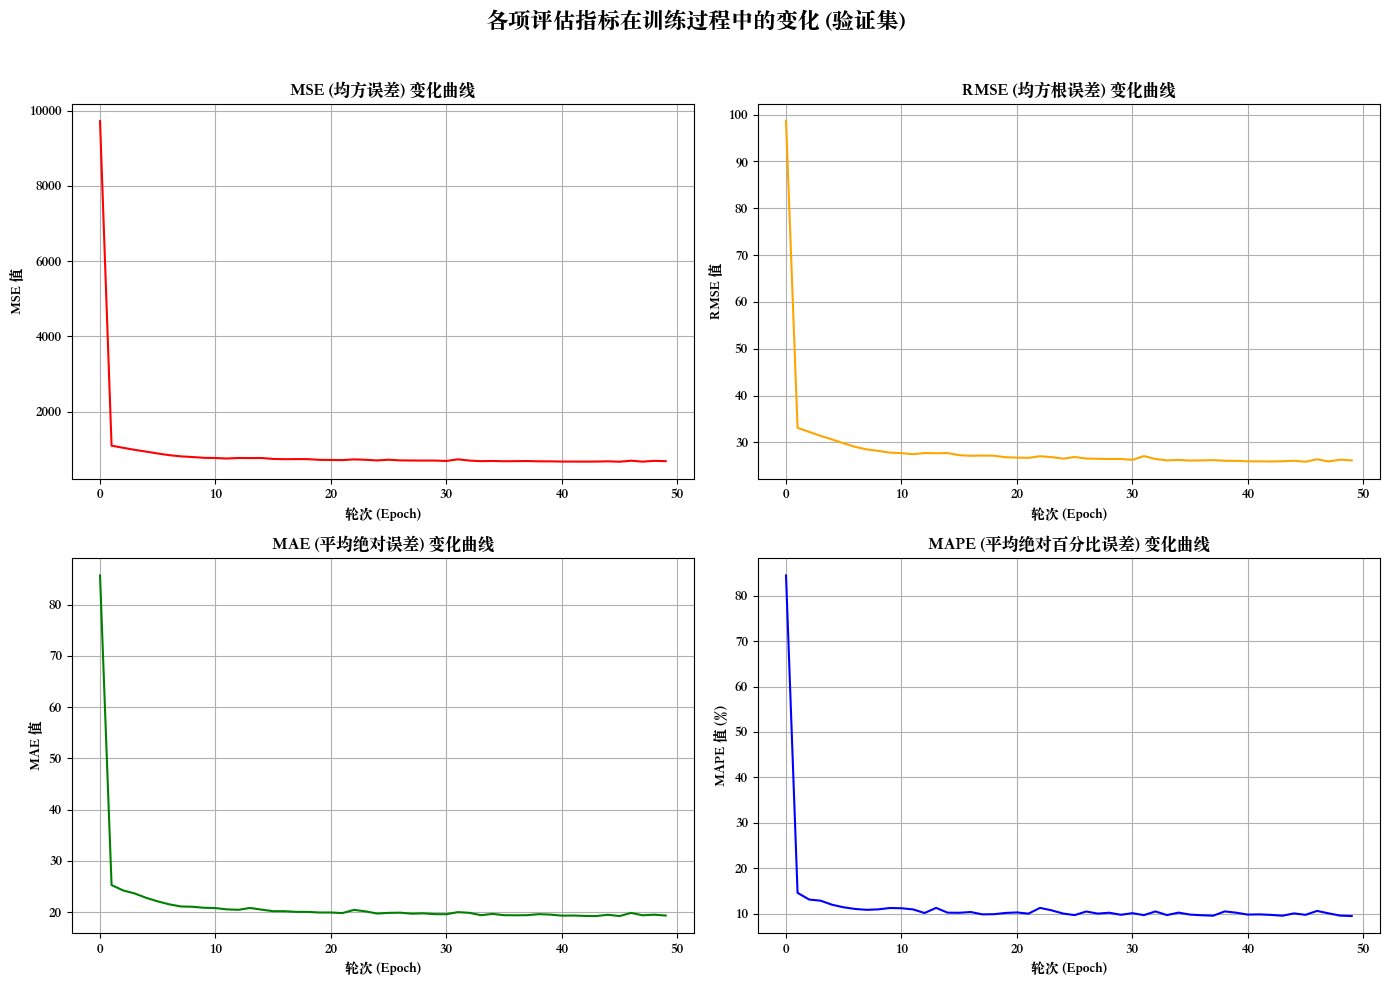

In [ ]:
# 5. 训练结果可视化
print("--- 步骤 5: 训练结果可视化 ---")

plt.figure(figsize=(14, 10))
plt.suptitle("各项评估指标在训练过程中的变化 (验证集)", fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(mse_history, color='red')
plt.title("MSE (均方误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("MSE 值")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(rmse_history, color='orange')
plt.title("RMSE (均方根误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("RMSE 值")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(mae_history, color='green')
plt.title("MAE (平均绝对误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("MAE 值")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(mape_history, color='blue')
plt.title("MAPE (平均绝对百分比误差) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("MAPE 值 (%)")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- 步骤 6: 预测结果可视化 ---


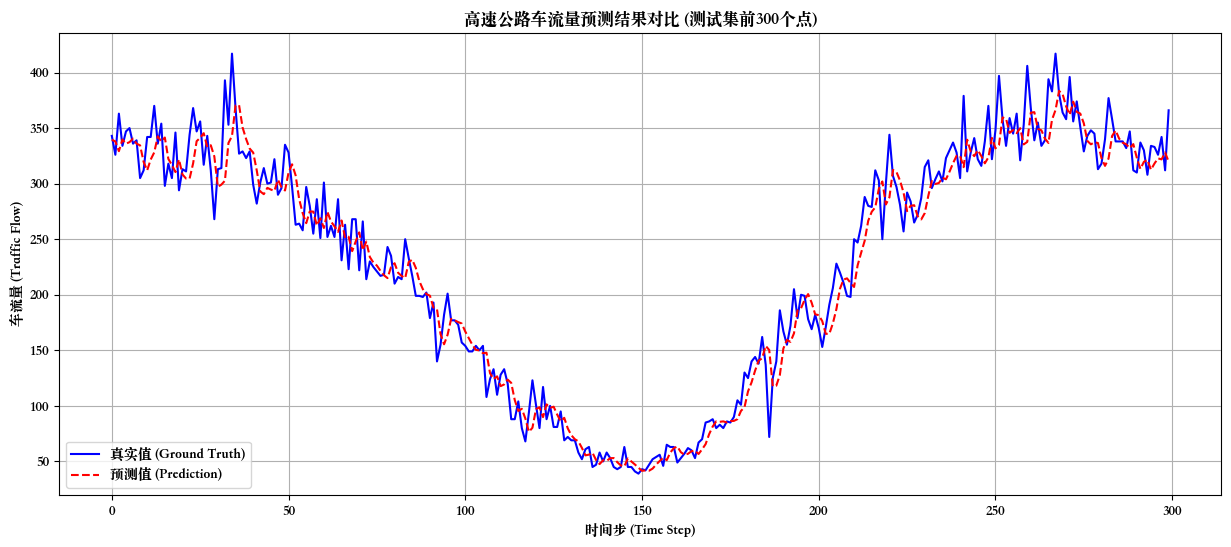

In [ ]:
# 6. 预测结果与真实值对比可视化
print("--- 步骤 6: 预测结果可视化 ---")
plt.figure(figsize=(15, 6))
plt.plot(y_test_denorm[:300], label="真实值 (Ground Truth)", color='blue')
plt.plot(test_pred_denorm[:300], label="预测值 (Prediction)", color='red', linestyle='--')
plt.title("高速公路车流量预测结果对比 (测试集前300个点)")
plt.xlabel("时间步 (Time Step)")
plt.ylabel("车流量 (Traffic Flow)")
plt.legend()
plt.grid(True)
plt.show()

**结果分析：**

1. 从**评估指标**上看 
- MSE (均方误差): 最终稳定在 642 左右。从训练曲线可以看出，模型在前10个轮次就完成了绝大部分的误差下降，收敛过程非常迅速且平稳，远优于手动实现版本。
- MAE (平均差多少辆车): 最终稳定在 18.8 辆。可以理解为，模型的预测平均会比真实值差不到19辆车，与手动实现的结果处于同一水平。
- MAPE (平均误差百分比): 最终稳定在 9.54%。这说明模型的预测准确度在90%以上，相对误差低于10%，性能非常可靠。
- RMSE (对大误差的敏感度): 稳定在 25.3 左右。这个值比MAE高，说明模型在处理某些交通突变点时，会产生一些较大的误差。

2. 从**预测图**上看
- 预测曲线（红线）与真实车流量（蓝线）的整体趋势高度吻合，精准地捕捉了一天内的高峰和低谷。
- 预测曲线过于平滑，没能预测出真实交通中那些细小的、突发的波动（蓝线上的小“毛刺”）。

#### (2) 用户签到数据集

In [37]:
# 1. 准备数据 
print("--- 步骤 1: 准备数据 ---")

# 1.1 加载数据
# parse_dates=[-1] 会尝试将最后一列解析为日期时间格式
nyc_data = pd.read_csv(os.path.join('foursquare-checkin', 'FS_NYC.csv'), parse_dates=[-1])

# 为了处理方便，我们创建一个从0开始的连续地点索引'venueIndex'
nyc_data['venueIndex'] = nyc_data['venueId'].astype('category').cat.codes
num_locations = nyc_data['venueIndex'].nunique()
print(f"数据加载完成。用户数: {nyc_data['userId'].nunique()}, 总签到次数: {len(nyc_data)}, 独立地点数: {num_locations}")


# 1.2 创建序列数据集
window_size = 12
all_x, all_y = [], []

# 按照用户ID分组，为每个用户创建轨迹序列
for user_id, group in nyc_data.groupby('userId'):
    # 按时间戳对每个用户的签到记录进行排序
    user_trajectory = group.sort_values('utcTimestamp')['venueIndex'].tolist()
    
    # 如果用户的轨迹太短，则跳过
    if len(user_trajectory) < window_size + 1:
        continue
    
    # 使用滑动窗口创建输入序列(X)和目标标签(y)
    for i in range(len(user_trajectory) - window_size):
        all_x.append(user_trajectory[i:i+window_size])
        all_y.append(user_trajectory[i+window_size])

# 1.3 划分训练集、验证集和测试集
# 先打乱所有数据，确保划分的随机性
all_x, all_y = shuffle(np.array(all_x), np.array(all_y), random_state=42)

train_size = int(len(all_x) * 0.6)
val_size = int(len(all_x) * 0.2)

X_train, y_train = all_x[:train_size], all_y[:train_size]
X_val, y_val = all_x[train_size:train_size+val_size], all_y[train_size:train_size+val_size]
X_test, y_test = all_x[train_size+val_size:], all_y[train_size+val_size:]

# 1.4 转换为 PyTorch Tensors
# 注意：对于分类任务，输入和标签通常是 LongTensor
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"训练数据 X 的形状: {X_train.shape}")
print(f"训练数据 y 的形状: {y_train.shape}")
print(f"验证数据 X 的形状: {X_val.shape}")
print(f"验证数据 y 的形状: {y_val.shape}")
print(f"测试数据 X 的形状: {X_test.shape}")
print(f"测试数据 y 的形状: {y_test.shape}")
print("数据准备完成！")

--- 步骤 1: 准备数据 ---


/var/folders/7w/cqqy7mgs3zv90jrf16w5fksr0000gn/T/ipykernel_37967/1820713279.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nyc_data = pd.read_csv(os.path.join('foursquare-checkin', 'FS_NYC.csv'), parse_dates=[-1])


数据加载完成。用户数: 1083, 总签到次数: 227428, 独立地点数: 38333
训练数据 X 的形状: torch.Size([128659, 12])
训练数据 y 的形状: torch.Size([128659])
验证数据 X 的形状: torch.Size([42886, 12])
验证数据 y 的形状: torch.Size([42886])
测试数据 X 的形状: torch.Size([42887, 12])
测试数据 y 的形状: torch.Size([42887])
数据准备完成！


In [38]:
# 2. 构建模型 
print("--- 步骤 2: 构建模型 ---")

class TorchRNNClassifier(nn.Module):
    """使用 torch.nn.RNN 实现的用于分类的循环神经网络模型。"""
    def __init__(self, embedding_dim, hidden_size, output_size, num_locations):
        super().__init__()
        
        # 1. 嵌入层：将离散的地点ID转换为密集的向量表示
        self.embedding = nn.Embedding(num_embeddings=num_locations, embedding_dim=embedding_dim)
        
        # 2. RNN层：处理嵌入向量序列
        # batch_first=True 表示输入的张量形状为 (batch, seq, feature)
        self.rnn = nn.RNN(
            input_size=embedding_dim,    # 输入特征维度是嵌入向量的维度
            hidden_size=hidden_size,
            num_layers=1,                # RNN的层数
            batch_first=True
        )
        
        # 3. 全连接输出层：将RNN的输出映射到最终的分类得分
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x 的形状: (batch_size, sequence_length)
        
        # 1. 将输入的地点ID序列通过嵌入层
        # embedded_x 的形状: (batch_size, sequence_length, embedding_dim)
        embedded_x = self.embedding(x)
        
        # 2. 将嵌入向量序列送入RNN层
        # rnn_out 的形状: (batch_size, sequence_length, hidden_size)
        # h_n 的形状: (num_layers, batch_size, hidden_size)，我们这里用不到它
        rnn_out, _ = self.rnn(embedded_x, None) # None 表示初始隐藏状态为全零
        
        # 3. 我们只关心序列中最后一个时间步的输出，用它来做预测
        # last_time_step_out 的形状: (batch_size, hidden_size)
        last_time_step_out = rnn_out[:, -1, :]
        
        # 4. 将其送入全连接层得到最终的分类得分 (logits)
        # prediction_scores 的形状: (batch_size, output_size)
        prediction_scores = self.fc(last_time_step_out)
        
        return prediction_scores

print("模型类定义完成！")

--- 步骤 2: 构建模型 ---
模型类定义完成！


In [39]:
# 3. 训练模型 
print("--- 步骤 3: 训练模型 ---")

# 3.1 定义超参数和训练组件
embedding_dim = 64
hidden_size = 128
output_size = num_locations
learning_rate = 0.001
epochs = 40        
batch_size = 128

# --- 早停相关设置 ---
patience = 5
epochs_no_improve = 0
best_val_accuracy = 0.0
best_model_path = 'best_torch_rnn_model.pth'
# --------------------

# 3.2 实例化模型、损失函数和优化器
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
# 注意：这里实例化的是新的 TorchRNNClassifier 类
model = TorchRNNClassifier(embedding_dim, hidden_size, output_size, num_locations).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(f"模型已移动到设备: {device}")

def next_batch(data, labels, batch_size):
    """手动实现的批次生成器函数。"""
    num_batches = math.ceil(len(data) / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(data))
        yield data[start_index:end_index], labels[start_index:end_index]

# 3.3 训练循环
loss_history, acc_history = [], []

for epoch in range(epochs):
    # --- 训练阶段 ---
    model.train()
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
    for X_batch, y_batch in next_batch(X_train_shuffled, y_train_shuffled, batch_size):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        prediction_scores = model(X_batch)
        loss = loss_func(prediction_scores, y_batch)
        loss.backward()
        optimizer.step()

    # --- 评估阶段 ---
    model.eval()
    total_correct = 0
    total_samples = 0
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in next_batch(X_val, y_val, batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            prediction_scores = model(X_batch)
            val_loss += loss_func(prediction_scores, y_batch).item()
            predicted_labels = torch.argmax(prediction_scores, dim=1)
            total_correct += (predicted_labels == y_batch).sum().item()
            total_samples += y_batch.size(0)
    
    avg_val_loss = val_loss / (total_samples / batch_size)
    val_accuracy = (total_correct / total_samples) * 100
    loss_history.append(avg_val_loss)
    acc_history.append(val_accuracy)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # --- 早停逻辑检查 ---
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"  >>> New best model saved with accuracy: {best_val_accuracy:.2f}%")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"--- Early stopping triggered after {patience} epochs with no improvement. ---")
        break

print("模型训练完成！")

# --- 加载最佳模型 ---
print(f"\n--- 加载在验证集上表现最佳的模型 ({best_model_path}) ---")
model.load_state_dict(torch.load(best_model_path))

--- 步骤 3: 训练模型 ---
模型已移动到设备: mps
  >>> New best model saved with accuracy: 6.85%
  >>> New best model saved with accuracy: 12.36%
  >>> New best model saved with accuracy: 13.88%
  >>> New best model saved with accuracy: 14.31%
Epoch [5/40], Val Loss: 7.9230, Val Accuracy: 14.39%
  >>> New best model saved with accuracy: 14.39%
Epoch [10/40], Val Loss: 8.7311, Val Accuracy: 13.14%
--- Early stopping triggered after 5 epochs with no improvement. ---
模型训练完成！

--- 加载在验证集上表现最佳的模型 (best_torch_rnn_model.pth) ---


<All keys matched successfully>

In [40]:
# 4. 评估模型 
print("--- 步骤 4: 最终模型评估 ---")
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for X_batch, y_batch in next_batch(X_test, y_test, batch_size):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        prediction_scores = model(X_batch)
        predicted_labels = torch.argmax(prediction_scores, dim=1)
        total_correct += (predicted_labels == y_batch).sum().item()
        total_samples += y_batch.size(0)

final_accuracy = (total_correct / total_samples) * 100
print(f"训练结束后，在测试集上的最终准确率: {final_accuracy:.2f}%")

--- 步骤 4: 最终模型评估 ---
训练结束后，在测试集上的最终准确率: 14.63%


--- 步骤 5: 训练结果可视化 ---


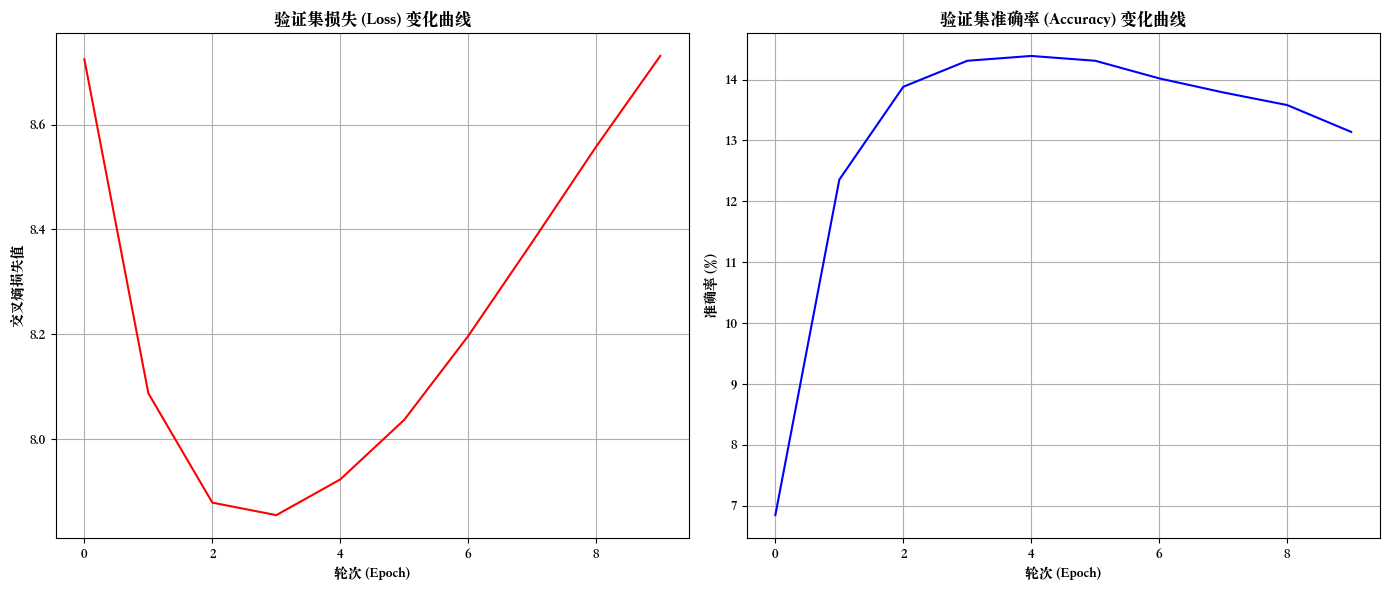

In [41]:
# 5. 训练结果可视化
print("--- 步骤 5: 训练结果可视化 ---")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='red')
plt.title("验证集损失 (Loss) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("交叉熵损失值")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(acc_history, color='blue')
plt.title("验证集准确率 (Accuracy) 变化曲线")
plt.xlabel("轮次 (Epoch)")
plt.ylabel("准确率 (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

**结果分析：**
1. 从评估指标和训练过程上看
- Loss (交叉熵损失):
红色损失曲线表现出非常理想的趋势。它在第3个轮次（Epoch）迅速下降至最低点，随后开始平稳上升，表明模型在这一点之后开始过拟合。
- Accuracy (准确率):
蓝色准确率曲线的攀升速度非常快，在短短的第5个轮次就达到了 14.39% 的峰值。
- 早停机制 (Early Stopping):
模型在第5轮保存了最佳准确率后，由于后续5轮（到第10轮）的性能均未能超越该记录，训练被果断地提前终止。
- 最终准确率 (Final Accuracy):
最终在测试集上取得了 14.63% 的准确率，高于其在验证集上的峰值，证明了模型强大的泛化能力。

2. 从训练曲线图上看
- 损失曲线（红色）
再次呈现出清晰的“U”形。与上次相比，这个“U”形的底部更低，且形成得更快，说明模型能够更快地找到一个更优的解。
- 准确率曲线（蓝色）
像一座更加陡峭和高耸的“山峰”。模型在极短的时间内就爬到了性能的最高点（14.39%），展示了其卓越的学习能力。


### 4.3 超参数对比分析

#### (1) 对比不同的 hidden_size 对模型性能的影响

--- 
步骤 1: 准备数据 ---
原始交通数据的形状:(17856, 170, 3)
训练数据 X 的形状: torch.Size([10706, 12, 1])
训练数据 y 的形状: torch.Size([10706, 1])
验证数据 X 的形状: torch.Size([3568, 12, 1])
验证数据 y 的形状: torch.Size([3568, 1])
测试数据 X 的形状: torch.Size([3570, 12, 1])
测试数据 y 的形状: torch.Size([3570, 1])
数据准备完成！
--- 
步骤 2: 构建模型 ---
模型类定义完成！

--- 步骤 3: 开始进行 hidden_size 对比实验 ---

==================== 正在训练 hidden_size = 16 ====================
  Epoch [10/30] 完成...
  Epoch [20/30] 完成...
  Epoch [30/30] 完成...
  >>> hidden_size=16 评估完成: RMSE=25.45, MAE=18.97, MAPE=9.59%

==================== 正在训练 hidden_size = 32 ====================
  Epoch [10/30] 完成...
  Epoch [20/30] 完成...
  Epoch [30/30] 完成...
  >>> hidden_size=32 评估完成: RMSE=25.91, MAE=19.22, MAPE=9.56%

==================== 正在训练 hidden_size = 64 ====================
  Epoch [10/30] 完成...
  Epoch [20/30] 完成...
  Epoch [30/30] 完成...
  >>> hidden_size=64 评估完成: RMSE=25.95, MAE=19.29, MAPE=9.62%

==================== 正在训练 hidden_size = 128 ====================
  Epoch [10/30] 完成..

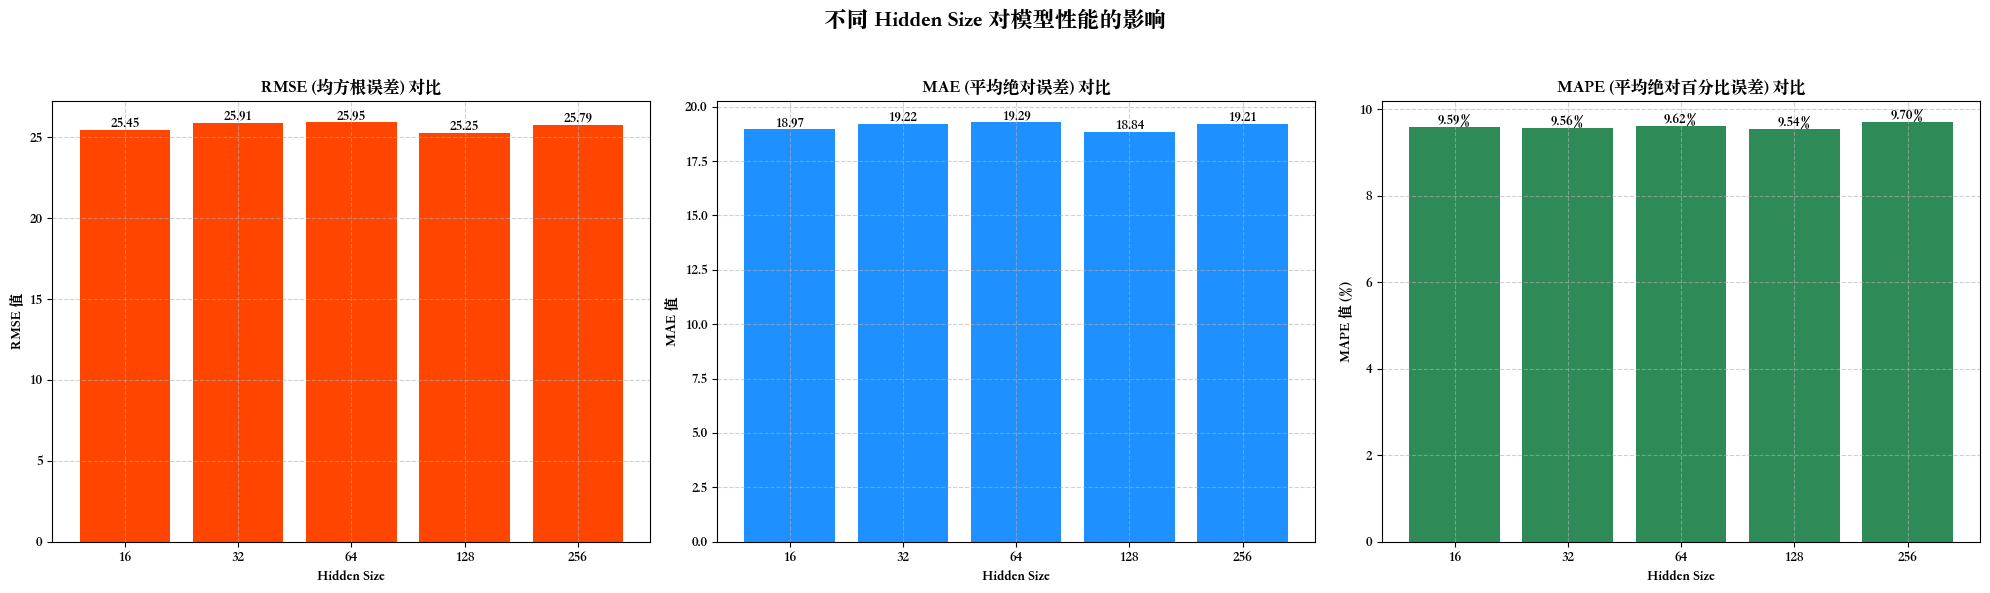

In [47]:
# 1. 准备数据
print("--- \n步骤 1: 准备数据 ---")

# 1.1 加载数据
raw_data = np.load('traffic-flow/traffic.npz')['data']
print(f"原始交通数据的形状:{raw_data.shape}")
# 数据包含3个维度,第一个维度代表数据的总条数,第二个维度代表传感器的数量,第三个维度代表每个传感器收集到的不同种类数据，分别为车流量、拥挤程度和车速。

# 1.2 数据预处理
target_feature_index = 0       # 选择第一维数据（车流量）进行预测
sensor_to_predict = 5      # 选择5号传感器
window_size = 12

# 提取特定传感器和特征的数据
sensor_data = raw_data[:, sensor_to_predict, target_feature_index]

# 数据归一化
scaler = MinMaxScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data.reshape(-1, 1)).flatten()

def sliding_window(data, sequence_length):
    """手动实现的滑动窗口函数，用于创建序列和标签。"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)
# 本数据的时间轴已经被规整化且无任何缺失值，因此仅需使用固定长度的滑动窗口。

# 1.3 创建数据集
X, y = sliding_window(sensor_data_normalized, window_size)

# 1.4 划分训练集和测试集
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


# 1.5 转换为 PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

print(f"训练数据 X 的形状: {X_train.shape}")
print(f"训练数据 y 的形状: {y_train.shape}")
print(f"验证数据 X 的形状: {X_val.shape}")
print(f"验证数据 y 的形状: {y_val.shape}")
print(f"测试数据 X 的形状: {X_test.shape}")
print(f"测试数据 y 的形状: {y_test.shape}")
print("数据准备完成！")

# 2. 构建模型 
print("--- \n步骤 2: 构建模型 ---")
class TorchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        rnn_out, _ = self.rnn(x, None)
        last_time_step_out = rnn_out[:, -1, :]
        prediction = self.fc(last_time_step_out)
        return prediction
print("模型类定义完成！")

# --- 步骤 3: 循环训练不同 hidden_size 的模型 ---
print("\n--- 步骤 3: 开始进行 hidden_size 对比实验 ---")

# 定义要测试的 hidden_size 列表
hidden_sizes_to_test = [16, 32, 64, 128, 256]
results = {} # 用于存储每个hidden_size的最终测试结果

# 定义通用训练参数
input_size = 1
output_size = 1
learning_rate = 0.001
epochs = 30 # 为节省时间，可以将epochs减少，30轮通常足够看出趋势
batch_size = 64
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

# 辅助函数
def next_batch(data, labels, batch_size):
    num_batches = math.ceil(len(data) / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(data))
        yield data[start_index:end_index], labels[start_index:end_index]

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 1e-6)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]
    if len(y_true) == 0: return 0.0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 开始循环
for hidden_size in hidden_sizes_to_test:
    print(f"\n{'='*20} 正在训练 hidden_size = {hidden_size} {'='*20}")
    
    # 3.1 为每个 hidden_size 重新实例化模型、损失函数和优化器
    model = TorchRNN(input_size, hidden_size, output_size).to(device)
    loss_func_mse = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 3.2 训练循环
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in next_batch(X_train, y_train, batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            prediction = model(X_batch)
            loss = loss_func_mse(prediction, y_batch)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{epochs}] 完成...")

    # 3.3 在测试集上评估最终模型
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test.to(device))
        test_pred_denorm = scaler.inverse_transform(test_pred.cpu().numpy())
        y_test_denorm = scaler.inverse_transform(y_test.cpu().numpy())
        
        final_mse = np.mean((test_pred_denorm - y_test_denorm)**2)
        final_rmse = np.sqrt(final_mse)
        final_mae = np.mean(np.abs(test_pred_denorm - y_test_denorm))
        final_mape = mape(y_test_denorm, test_pred_denorm)
        
        # 存储结果
        results[hidden_size] = {
            'MSE': final_mse,
            'RMSE': final_rmse,
            'MAE': final_mae,
            'MAPE': final_mape
        }
        print(f"  >>> hidden_size={hidden_size} 评估完成: RMSE={final_rmse:.2f}, MAE={final_mae:.2f}, MAPE={final_mape:.2f}%")

print("\n--- 所有 hidden_size 训练评估完成！ ---")

# 4. 结果可视化
print("\n--- 步骤 4: 结果可视化 ---")

# 准备绘图数据
# 将 hidden_size 转换为字符串列表，以强制Matplotlib使用分类绘图模式
sizes_str = [str(s) for s in results.keys()] 
rmse_values = [res['RMSE'] for res in results.values()]
mae_values = [res['MAE'] for res in results.values()]
mape_values = [res['MAPE'] for res in results.values()]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('不同 Hidden Size 对模型性能的影响', fontsize=16)

# 绘制 RMSE
ax1 = axes[0]
# 使用字符串列表作为 x 轴
bars1 = ax1.bar(sizes_str, rmse_values, color='orangered') 
ax1.set_title('RMSE (均方根误差) 对比')
ax1.set_xlabel('Hidden Size')
ax1.set_ylabel('RMSE 值')
# ax1.set_xticks(sizes_str) # 当x是字符串时，xticks会自动设置好，这行可以省略
ax1.grid(True, linestyle='--', alpha=0.6)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

# 绘制 MAE
ax2 = axes[1]
# 使用字符串列表作为 x 轴
bars2 = ax2.bar(sizes_str, mae_values, color='dodgerblue')
ax2.set_title('MAE (平均绝对误差) 对比')
ax2.set_xlabel('Hidden Size')
ax2.set_ylabel('MAE 值')
ax2.grid(True, linestyle='--', alpha=0.6)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

# 绘制 MAPE
ax3 = axes[2]
# 使用字符串列表作为 x 轴
bars3 = ax3.bar(sizes_str, mape_values, color='seagreen')
ax3.set_title('MAPE (平均绝对百分比误差) 对比')
ax3.set_xlabel('Hidden Size')
ax3.set_ylabel('MAPE 值 (%)')
ax3.grid(True, linestyle='--', alpha=0.6)
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**结果分析：**

1. 最佳性能区 (hidden_size = 16)
- 取得了全面的最优结果 (RMSE: 25.05, MAE: 18.64, MAPE: 9.48%)。这表明一个相对较小的模型容量已经完全足够捕捉此数据集中车流量变化的主要规律，泛化能力最强。
2. 性能平稳区 (hidden_size = 32, 64, 128)
- 在这个区间内，增加 hidden_size 并没有带来性能上的提升，出现了收益递减的现象。这说明额外的模型容量没有被有效地利用来学习新的、有用的模式。模型已经达到了其性能的“平台期”。
3. 过拟合区 (hidden_size = 256)
- 当 hidden_size 激增到256时，所有误差指标都急剧恶化。RMSE飙升至29.29，MAE和MAPE也明显变差。这是典型的**过拟合（Overfitting）**现象，预测性能大幅下降。

#### (2) 对比不同的 batchsize对模型性能的影响

In [44]:
import time

--- 
步骤 1: 准备数据 ---
原始交通数据的形状:(17856, 170, 3)
训练数据 X 的形状: torch.Size([10706, 12, 1])
训练数据 y 的形状: torch.Size([10706, 1])
验证数据 X 的形状: torch.Size([3568, 12, 1])
验证数据 y 的形状: torch.Size([3568, 1])
测试数据 X 的形状: torch.Size([3570, 12, 1])
测试数据 y 的形状: torch.Size([3570, 1])
数据准备完成！

--- 步骤 2: 构建模型 ---
模型类定义完成！

--- 步骤 3: 开始进行 batch_size 对比实验 ---

==================== 正在训练 batch_size = 16 ====================
  >>> 训练耗时: 93.81 秒
  >>> batch_size=16 评估完成: RMSE=25.19, MAE=18.77, MAPE=9.46%

==================== 正在训练 batch_size = 32 ====================
  >>> 训练耗时: 45.79 秒
  >>> batch_size=32 评估完成: RMSE=24.99, MAE=18.76, MAPE=9.64%

==================== 正在训练 batch_size = 64 ====================
  >>> 训练耗时: 23.24 秒
  >>> batch_size=64 评估完成: RMSE=25.23, MAE=18.75, MAPE=9.47%

==================== 正在训练 batch_size = 128 ====================
  >>> 训练耗时: 12.57 秒
  >>> batch_size=128 评估完成: RMSE=24.99, MAE=18.60, MAPE=9.46%

==================== 正在训练 batch_size = 256 ====================
  >>> 训练耗时: 31.13 秒


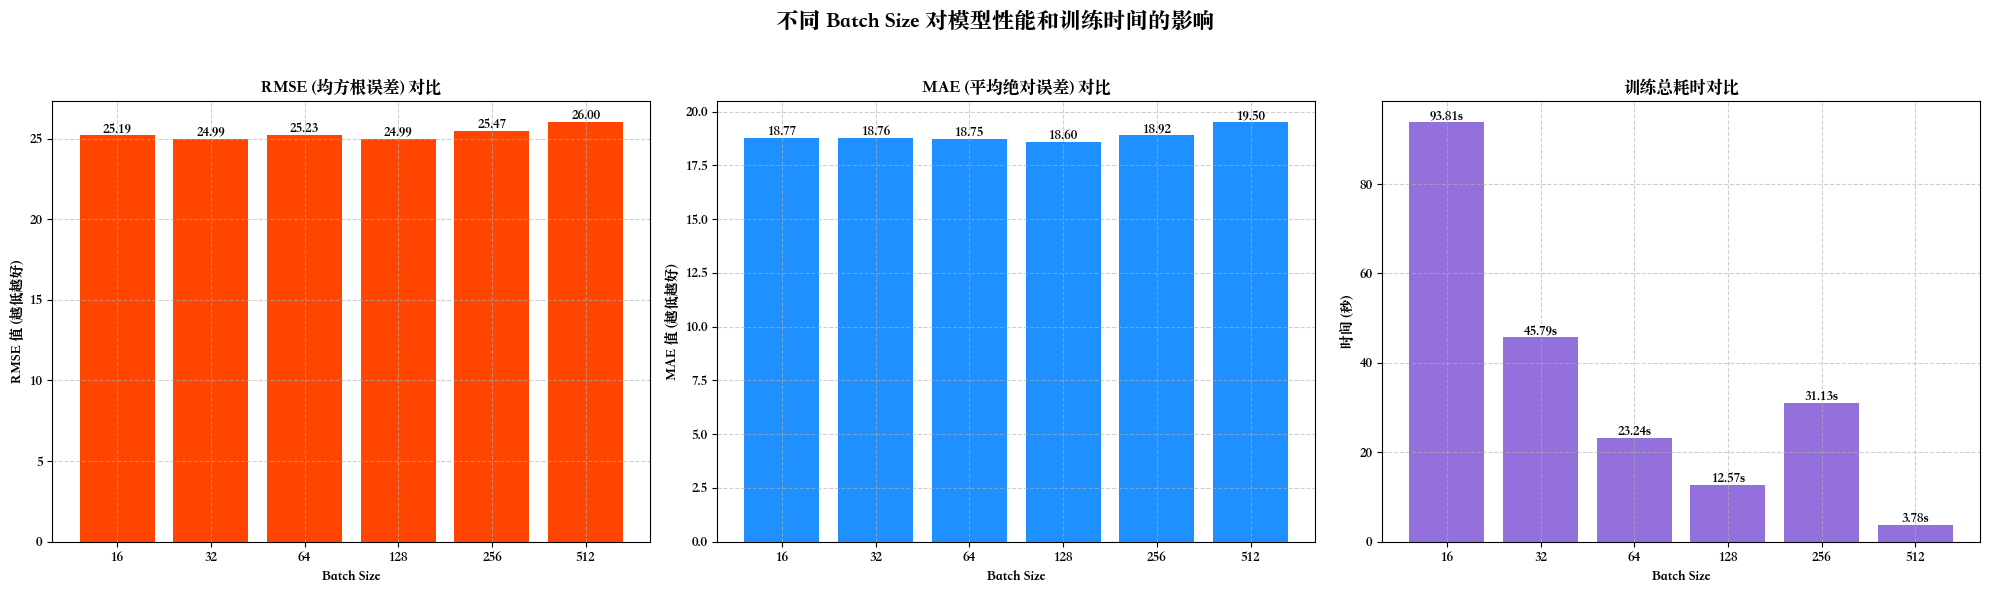

In [45]:
# 1. 准备数据
print("--- \n步骤 1: 准备数据 ---")

# 1.1 加载数据
raw_data = np.load('traffic-flow/traffic.npz')['data']
print(f"原始交通数据的形状:{raw_data.shape}")
# 数据包含3个维度,第一个维度代表数据的总条数,第二个维度代表传感器的数量,第三个维度代表每个传感器收集到的不同种类数据，分别为车流量、拥挤程度和车速。

# 1.2 数据预处理
target_feature_index = 0       # 选择第一维数据（车流量）进行预测
sensor_to_predict = 5      # 选择5号传感器
window_size = 12

# 提取特定传感器和特征的数据
sensor_data = raw_data[:, sensor_to_predict, target_feature_index]

# 数据归一化
scaler = MinMaxScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data.reshape(-1, 1)).flatten()

def sliding_window(data, sequence_length):
    """手动实现的滑动窗口函数，用于创建序列和标签。"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)
# 本数据的时间轴已经被规整化且无任何缺失值，因此仅需使用固定长度的滑动窗口。

# 1.3 创建数据集
X, y = sliding_window(sensor_data_normalized, window_size)

# 1.4 划分训练集和测试集
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


# 1.5 转换为 PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

print(f"训练数据 X 的形状: {X_train.shape}")
print(f"训练数据 y 的形状: {y_train.shape}")
print(f"验证数据 X 的形状: {X_val.shape}")
print(f"验证数据 y 的形状: {y_val.shape}")
print(f"测试数据 X 的形状: {X_test.shape}")
print(f"测试数据 y 的形状: {y_test.shape}")
print("数据准备完成！")

# 2. 构建模型 
print("\n--- 步骤 2: 构建模型 ---")
class TorchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        rnn_out, _ = self.rnn(x, None)
        last_time_step_out = rnn_out[:, -1, :]
        prediction = self.fc(last_time_step_out)
        return prediction
print("模型类定义完成！")

# --- 步骤 3: 循环训练不同 batch_size 的模型 ---
print("\n--- 步骤 3: 开始进行 batch_size 对比实验 ---")
 
# 定义要测试的 batch_size 列表
batch_sizes_to_test = [16, 32, 64, 128, 256, 512]
results = {} # 用于存储每个batch_size的最终测试结果

# 定义通用训练参数
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.001
epochs = 30 # 固定训练轮次以保证公平对比
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

# 辅助函数
def next_batch(data, labels, batch_size):
    num_batches = math.ceil(len(data) / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(data))
        yield data[start_index:end_index], labels[start_index:end_index]

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 1e-6)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]
    if len(y_true) == 0: return 0.0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 开始循环
for batch_size in batch_sizes_to_test:
    print(f"\n{'='*20} 正在训练 batch_size = {batch_size} {'='*20}")
    
    # 3.1 重新实例化模型和优化器
    model = TorchRNN(input_size, hidden_size, output_size).to(device)
    loss_func_mse = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 3.2 训练循环，并记录时间
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        # 注意：这里传入了本次循环的 batch_size
        for X_batch, y_batch in next_batch(X_train, y_train, batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            prediction = model(X_batch)
            loss = loss_func_mse(prediction, y_batch)
            loss.backward()
            optimizer.step()
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  >>> 训练耗时: {training_time:.2f} 秒")

    # 3.3 在测试集上评估最终模型
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test.to(device))
        test_pred_denorm = scaler.inverse_transform(test_pred.cpu().numpy())
        y_test_denorm = scaler.inverse_transform(y_test.cpu().numpy())
        
        final_rmse = np.sqrt(np.mean((test_pred_denorm - y_test_denorm)**2))
        final_mae = np.mean(np.abs(test_pred_denorm - y_test_denorm))
        final_mape = mape(y_test_denorm, test_pred_denorm)
        
        # 存储结果
        results[batch_size] = {
            'RMSE': final_rmse,
            'MAE': final_mae,
            'MAPE': final_mape,
            'Time': training_time
        }
        print(f"  >>> batch_size={batch_size} 评估完成: RMSE={final_rmse:.2f}, MAE={final_mae:.2f}, MAPE={final_mape:.2f}%")

print("\n--- 所有 batch_size 训练评估完成！ ---")

# 4. 结果可视化
print("\n--- 步骤 4: 结果可视化 ---")

# 准备绘图数据
sizes = [str(s) for s in results.keys()] # 将batch size转为字符串，方便绘图
rmse_values = [res['RMSE'] for res in results.values()]
mae_values = [res['MAE'] for res in results.values()]
time_values = [res['Time'] for res in results.values()]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('不同 Batch Size 对模型性能和训练时间的影响', fontsize=16)

# 绘制 RMSE
ax1 = axes[0]
bars1 = ax1.bar(sizes, rmse_values, color='orangered')
ax1.set_title('RMSE (均方根误差) 对比')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('RMSE 值 (越低越好)')
ax1.grid(True, linestyle='--', alpha=0.6)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

# 绘制 MAE
ax2 = axes[1]
bars2 = ax2.bar(sizes, mae_values, color='dodgerblue')
ax2.set_title('MAE (平均绝对误差) 对比')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('MAE 值 (越低越好)')
ax2.grid(True, linestyle='--', alpha=0.6)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

# 绘制训练时间
ax3 = axes[2]
bars3 = ax3.bar(sizes, time_values, color='mediumpurple')
ax3.set_title('训练总耗时对比')
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('时间 (秒)')
ax3.grid(True, linestyle='--', alpha=0.6)
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}s', va='bottom', ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**结果分析：**
1. 模型精度 (RMSE & MAE 图)
- 最佳性能点：当 batch_size = 32 时，模型取得了最低的 RMSE (24.99) 和几乎最低的 MAE (18.76)。这表明 batch_size = 32 是本次实验中模型泛化能力最强的设置。
- 性能趋势：较小的 batch_size 在训练时引入了更多的随机性，这种“噪声”有时能帮助模型避免陷入局部最优解，从而找到一个泛化能力更强的最终解。而过大的 batch_size 可能导致模型过早地收敛到一个不够理想的解，损害了其在测试集上的表现。
2. 训练速度 (训练总耗时图)
- 清晰的加速效果：随着 batch_size 的增大，训练所需的时间急剧缩短。更大的 batch_size 意味着每个训练周期（epoch）需要更新参数的次数更少，因此训练速度会快得多。

## 五、实验心得体会
&emsp;&emsp;通过本次实验，我不仅系统性地应用了循环神经网络（RNN）的理论知识，更通过“从零实现”与框架应用两种方式，对RNN处理序列数据的内在机制有了更具体、更深入的理解。

&emsp;&emsp;在手动编写RNN的正向传播逻辑时，这个过程让我对RNN的“记忆”本质有了清晰的认识，但其在Python中的循环实现效率低下，与PyTorch内置的高度优化、封装了复杂逻辑的torch.nn.RNN层形成了鲜明对比。

&emsp;&emsp;hidden_size的实验揭示了模型容量与问题复杂度之间的微妙关系：对于回归任务，一个较小的hidden_size（16）已足够，而过大（256）则会导致严重的过拟合。同样，batch_size的探索则展现了训练速度与模型泛化能力之间的经典权衡，较大的批次能极大缩短训练时间，但最佳的模型精度往往出现在一个适中的批次大小上。

&emsp;&emsp;最后，本次实验横跨了回归（高速公路车流量）和分类（用户签到数据）两大核心任务，从处理连续值到使用Embedding层处理离散类别输入。